In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv


In [64]:
!pip install --upgrade pip
!pip install git+https://github.com/tensorflow/docs

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (20.2.3)
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6t1ejg6o
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0709b001a70c0b88de2dcc313df0739fc75948d5e_-py3-none-any.whl size=143847 sha256=d68ca3030269a3b32176b4c83504e57b0126b0abe5d527993c30a06b431bcc21
  Stored in directory: /tmp/pip-ephem-wheel-cache-e0jk9429/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [65]:
import glob
import imageio
import time 
import keras
import PIL
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt

from keras import Sequential
from keras.optimizers import Adam
import tensorflow_docs.vis.embed as embed
from keras.losses import BinaryCrossentropy


In [66]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()


In [67]:
train_images = train_images.reshape(-1, 28, 28,1)
train_images = (train_images - 127.5) / 127.5
images = train_images

In [68]:
train_images.shape ,train_labels.shape

((60000, 28, 28, 1), (60000,))

In [69]:
learning_rate = 0.0001
batch_size = 256
epochs = 500
break_num = 5
image_dim = train_images[0].shape
random_noise = 100

In [70]:
image_dim

(28, 28, 1)

# Discriminator model

In [71]:
from keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, BatchNormalization, Reshape, Conv2DTranspose, Conv1D

In [72]:
def discriminator():
    model = Sequential(name = "discriminator")
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=image_dim))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    
    model.summary()

    return model

In [73]:
def generator():
    model = Sequential(name="generator")
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))    # adding noise
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.summary()
    return model

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 128)         0 

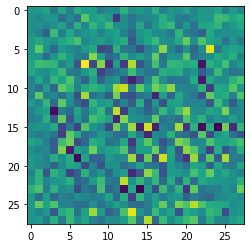

In [74]:
gen = generator()

noise = tf.random.normal([1, 100])
generated_image = gen(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [75]:
disc = discriminator()
print(disc(generated_image))

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)            

# Loss function

In [76]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [77]:
discriminator_optimizer = Adam(learning_rate)

generator_optimizer = Adam(learning_rate)


In [78]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=gen,
                                 discriminator=disc)

In [79]:
def train_step(input_image):
    noise = tf.random.normal([batch_size, random_noise])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(noise)

        real_output = disc(input_image)
        fake_output = disc(generated_images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    g_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
    g_disc = disc_tape.gradient(disc_loss, disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(g_gen, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(g_disc, disc.trainable_variables))
    return gen_loss, disc_loss

In [80]:
noise_gan = tf.random.normal([batch_size, random_noise])
def save_output(model, epoch):
    prediction = model(noise_gan)

    fig = plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

Time for epoch 1 is 10.415456771850586 sec and Generator Loss :3.4468326568603516 and Discriminator loss :0.3833513855934143
Time for epoch 6 is 10.042855739593506 sec and Generator Loss :1.0191948413848877 and Discriminator loss :1.1417535543441772
Time for epoch 11 is 10.032701253890991 sec and Generator Loss :0.8876444101333618 and Discriminator loss :1.2047767639160156
Time for epoch 16 is 10.112050771713257 sec and Generator Loss :1.0323445796966553 and Discriminator loss :1.2416958808898926
Time for epoch 21 is 9.86810851097107 sec and Generator Loss :0.8955332040786743 and Discriminator loss :1.2281816005706787
Time for epoch 26 is 10.264815330505371 sec and Generator Loss :1.3827576637268066 and Discriminator loss :0.9619464874267578
Time for epoch 31 is 10.683779239654541 sec and Generator Loss :1.3209336996078491 and Discriminator loss :0.7735598087310791
Time for epoch 36 is 10.034898519515991 sec and Generator Loss :1.9045547246932983 and Discriminator loss :0.6978503465652

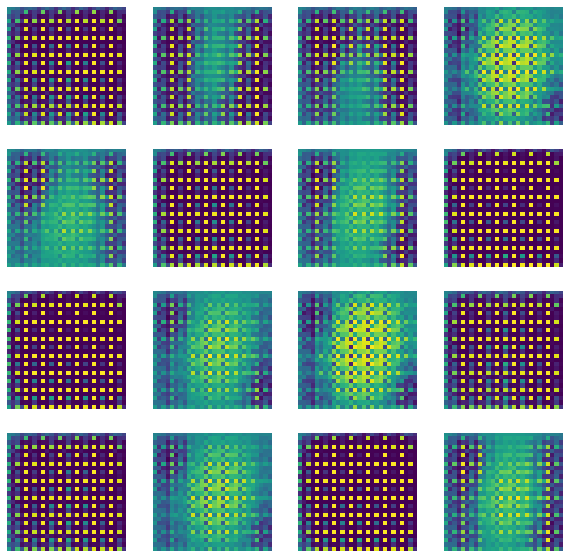

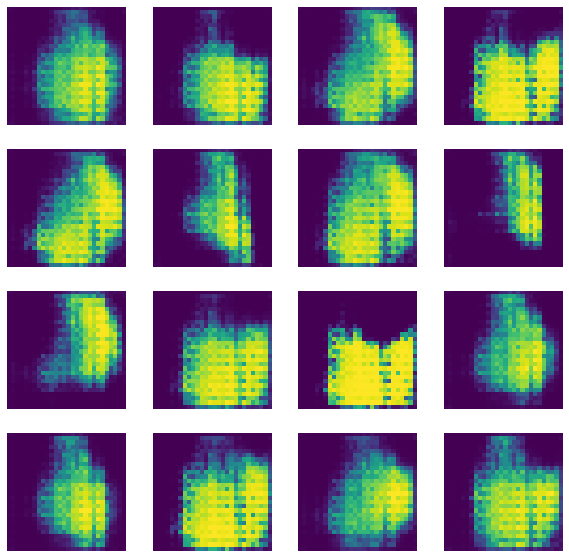

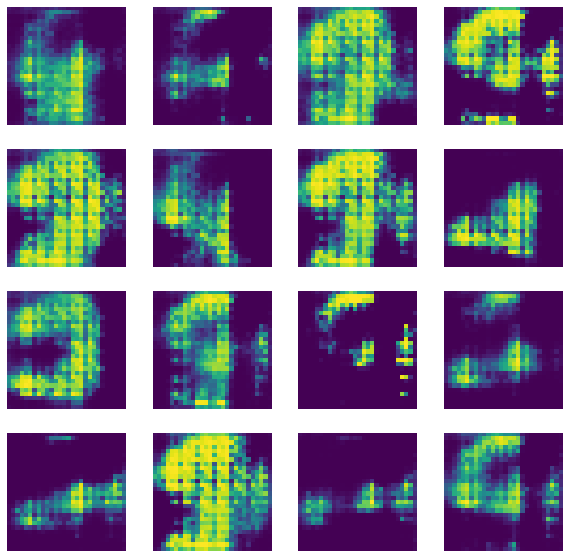

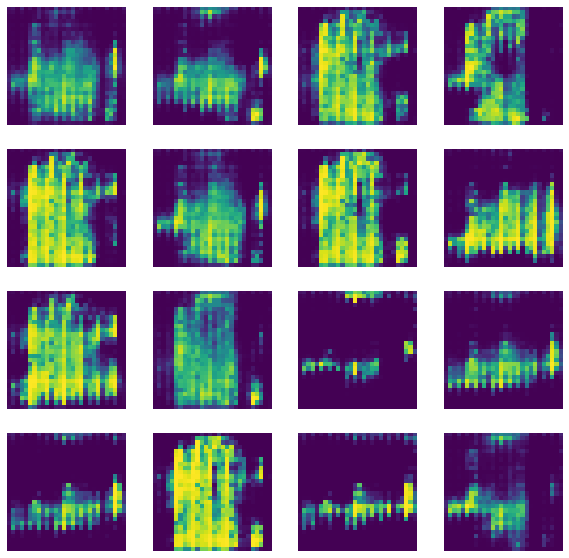

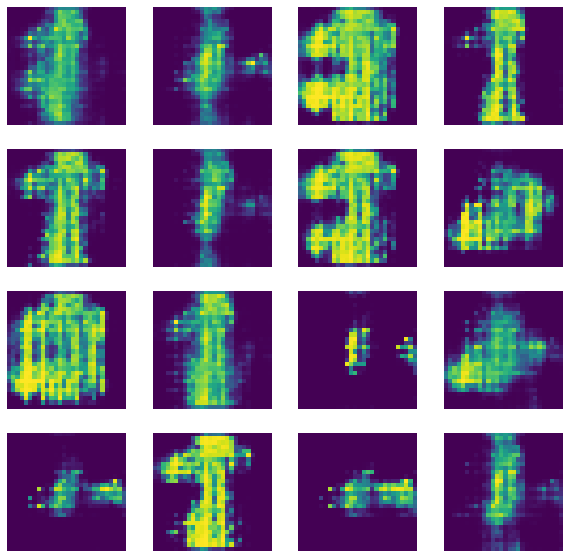

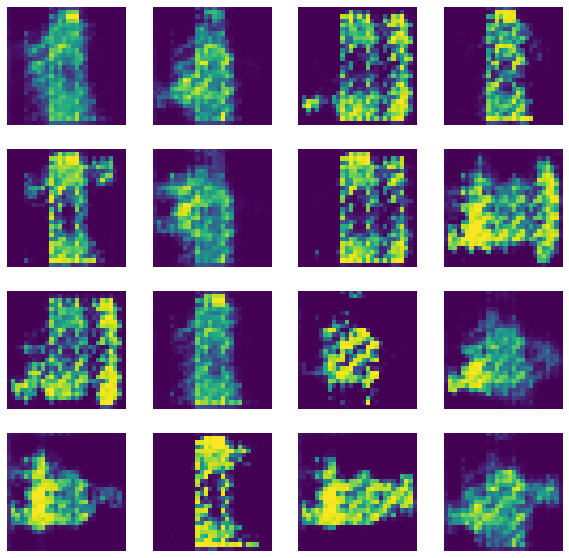

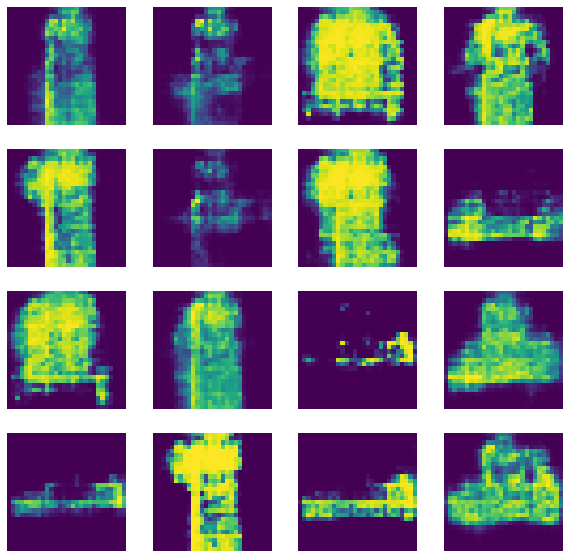

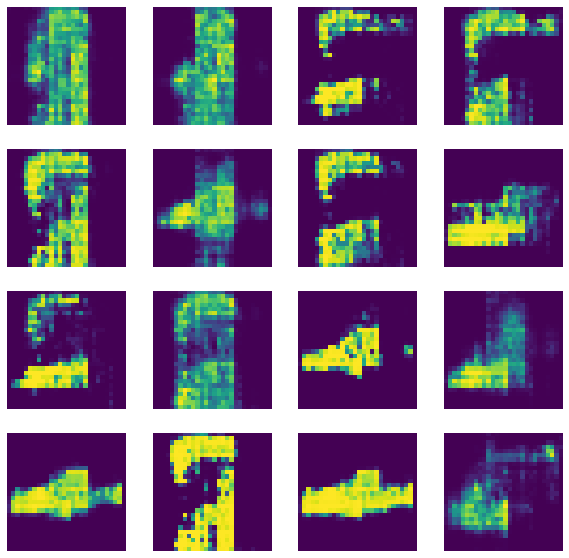

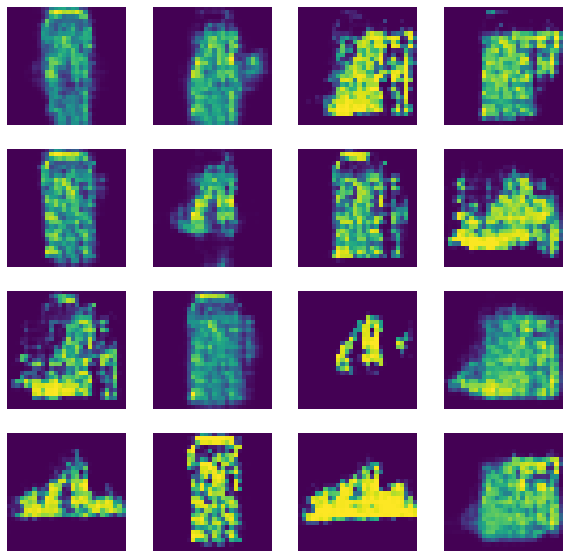

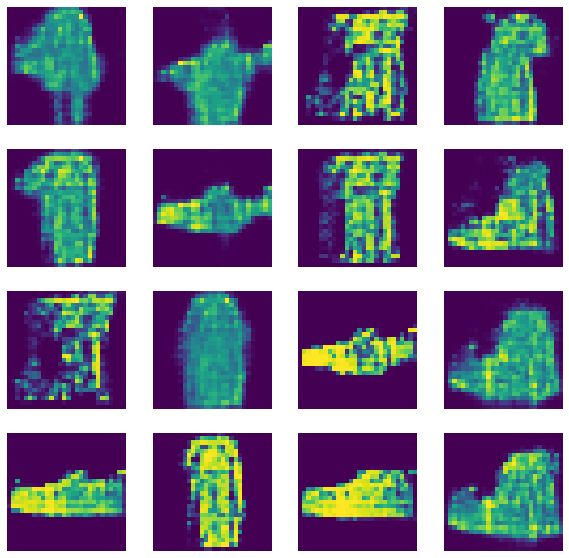

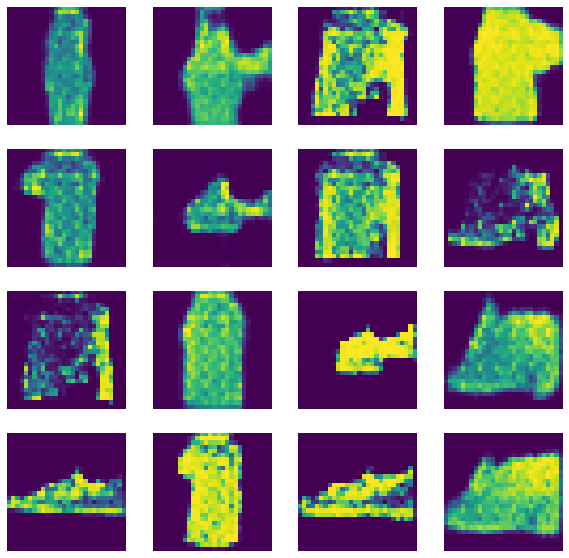

In [81]:
train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

for epoch in range(epochs):
    start = time.time()

    for x_batch in train_images:
        loss = train_step(x_batch)
        
    if (epoch + 1) % break_num == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    if epoch %break_num ==0 or epoch==epochs-1 and epoch!=0:
        print ('Time for epoch {} is {} sec and Generator Loss :{} and Discriminator loss :{}'.format(epoch + 1, time.time()-start, loss[0], loss[1]))
        save_output(gen, epoch+1)


In [94]:
def display_image(epoch_no, file):
    return PIL.Image.open(file.format(epoch_no))

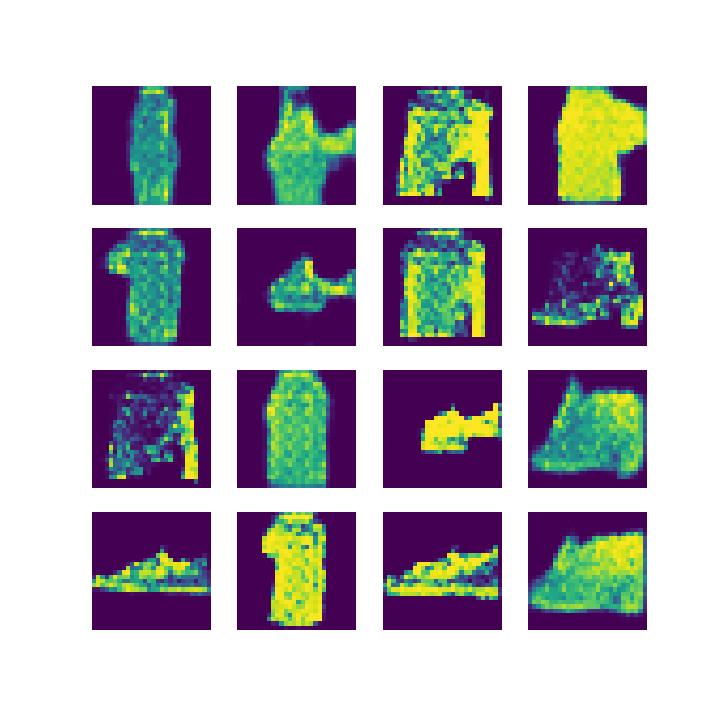

In [95]:
display_image(epoch+1, 'image_at_epoch_{:04d}.png')

In [84]:
def create_gif(file, collection):

    with imageio.get_writer(file, mode='I') as writer:
        filenames = glob.glob(collection+'*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
    return file


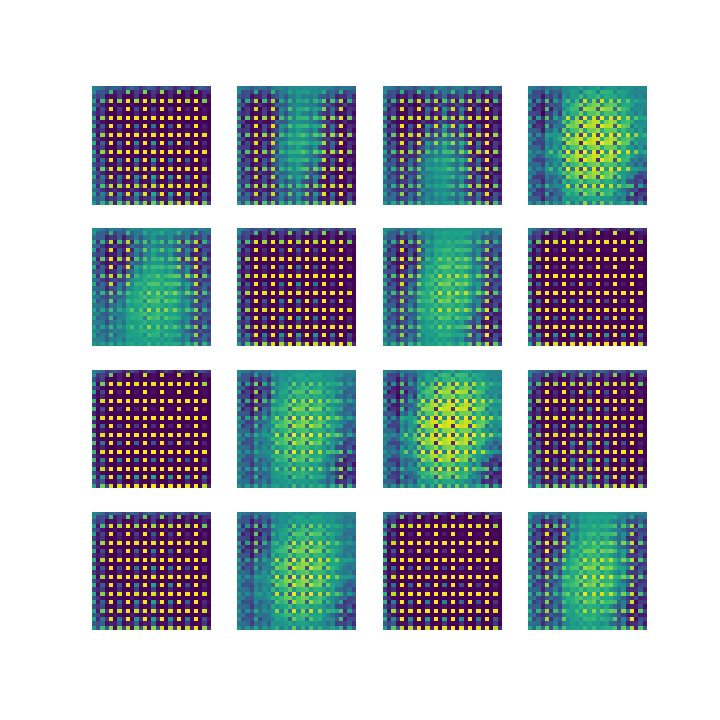

In [85]:
file  = create_gif("result.gif", "image")
embed.embed_file(file)

# Conditional GAN

In [86]:
from keras.utils import to_categorical

train_images = images
labels = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, labels)


In [87]:
learning_rate = 0.0001
batch_size = 64

random_noise = 100

In [88]:
def discriminator():
    model = Sequential(name = "discriminator")
    model.add(Dense(7*7*256, use_bias=False, input_shape=(794,)))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    
    return model

def generator():
    model = Sequential(name="generator")
    model.add(Dense(7*7*256, use_bias=False, input_shape=(110,)))    # adding noise
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(Reshape((784,)))
    
    return model


In [89]:
print(generator().summary())
print(discriminator().summary())

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12544)             1379840   
_________________________________________________________________
batch_normalization_12 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 7, 7, 128)         0 

In [90]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


discriminator_optimizer = Adam(learning_rate)

generator_optimizer = Adam(learning_rate)

Time for epoch 1 is 58.85890460014343 sec and Generator Loss :1.5300562381744385 and Discriminator loss :0.9609962701797485
Time for epoch 6 is 58.98466157913208 sec and Generator Loss :2.6252450942993164 and Discriminator loss :0.8421880602836609
Time for epoch 11 is 58.96594262123108 sec and Generator Loss :2.6430721282958984 and Discriminator loss :1.1795321702957153
Time for epoch 16 is 59.58293437957764 sec and Generator Loss :1.2949507236480713 and Discriminator loss :1.027566909790039
Time for epoch 21 is 60.46130013465881 sec and Generator Loss :0.7192773222923279 and Discriminator loss :1.6297471523284912
Time for epoch 26 is 59.57247853279114 sec and Generator Loss :1.1951112747192383 and Discriminator loss :1.3145240545272827
Time for epoch 31 is 59.409504652023315 sec and Generator Loss :0.9531632661819458 and Discriminator loss :1.3100229501724243
Time for epoch 36 is 58.6501202583313 sec and Generator Loss :0.9244286417961121 and Discriminator loss :1.2600843906402588
Tim

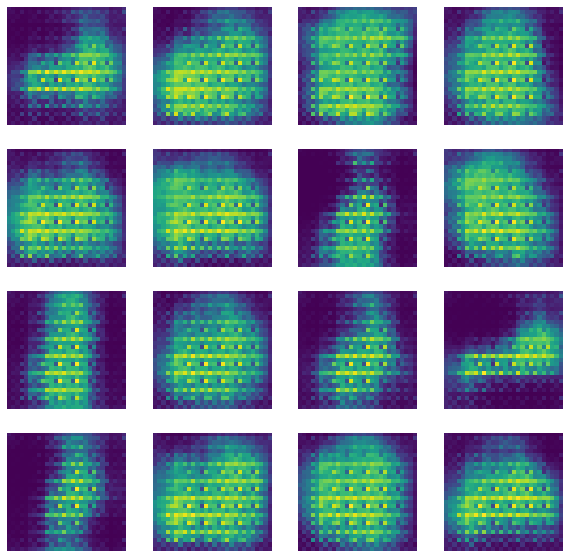

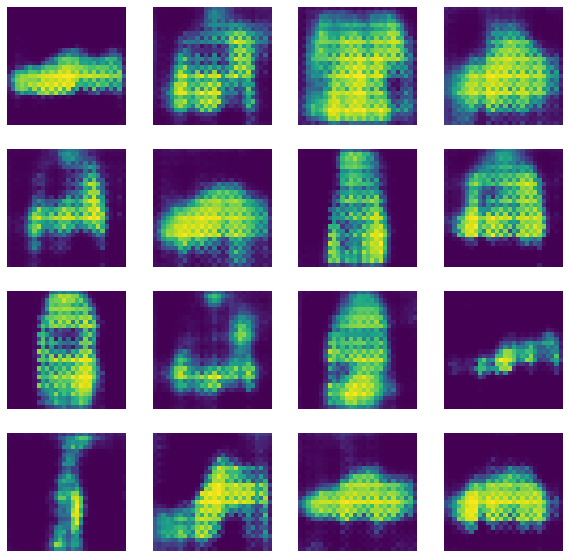

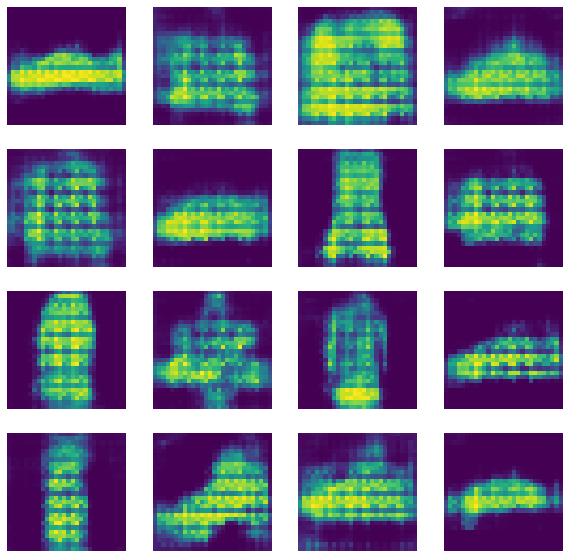

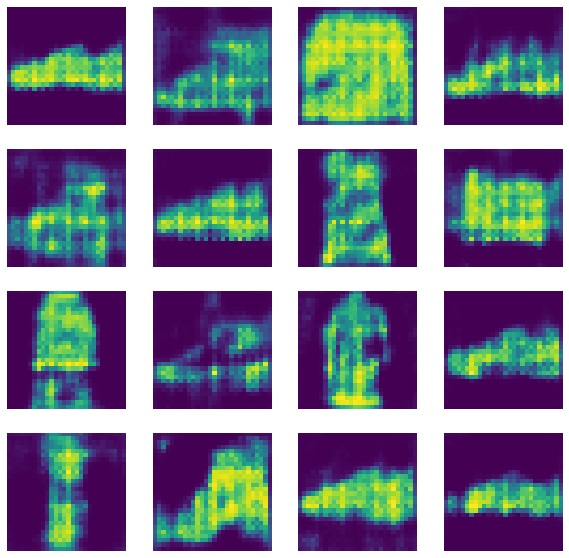

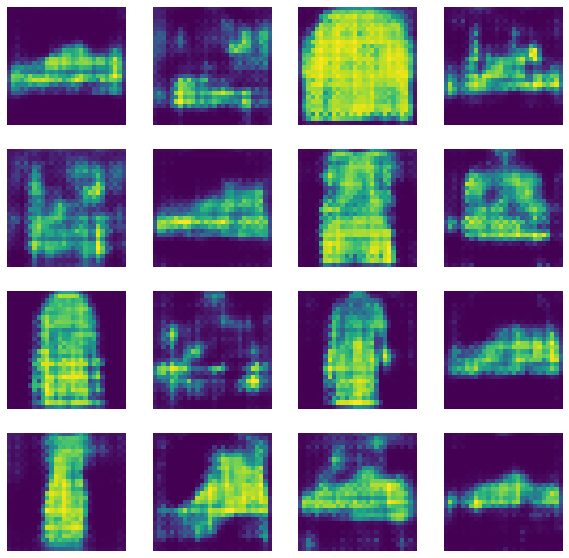

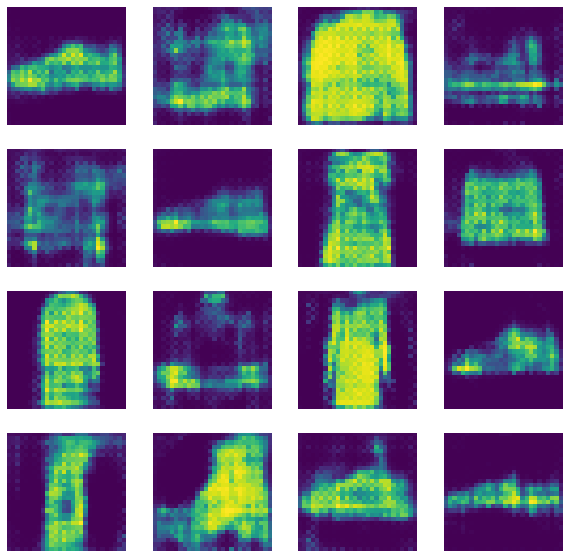

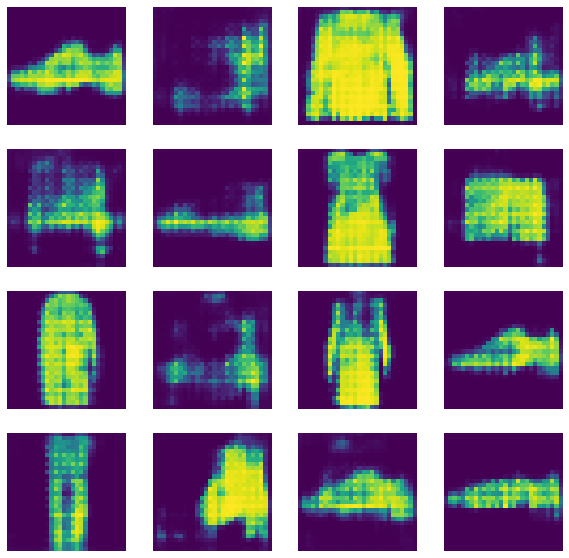

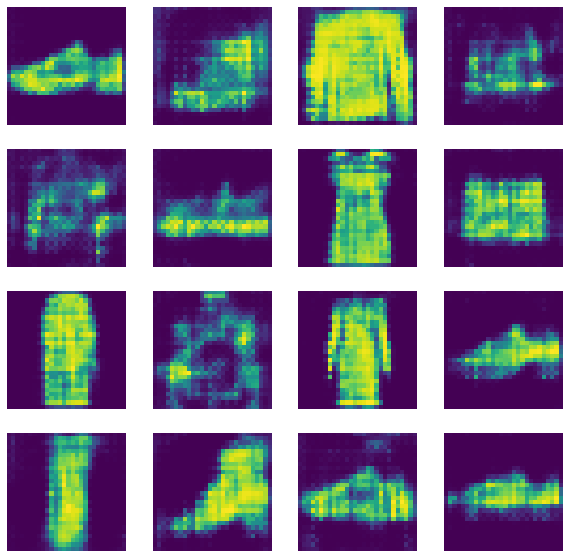

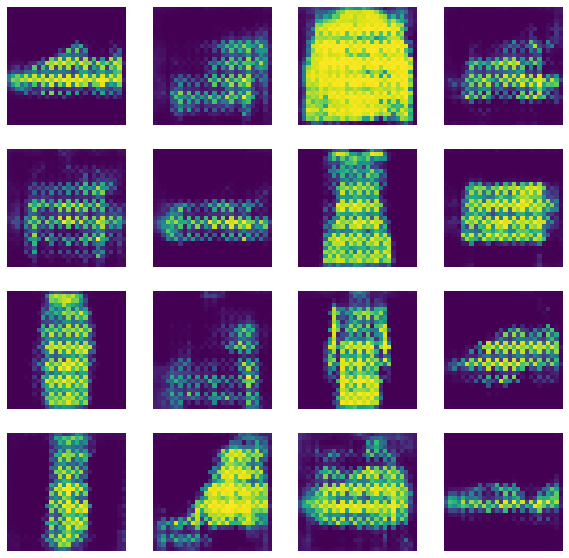

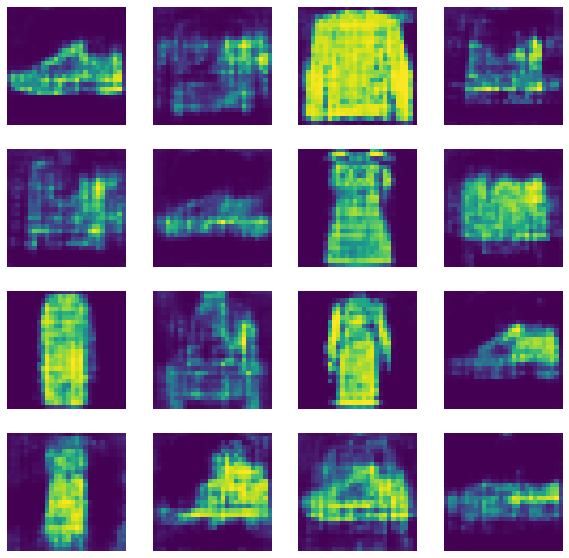

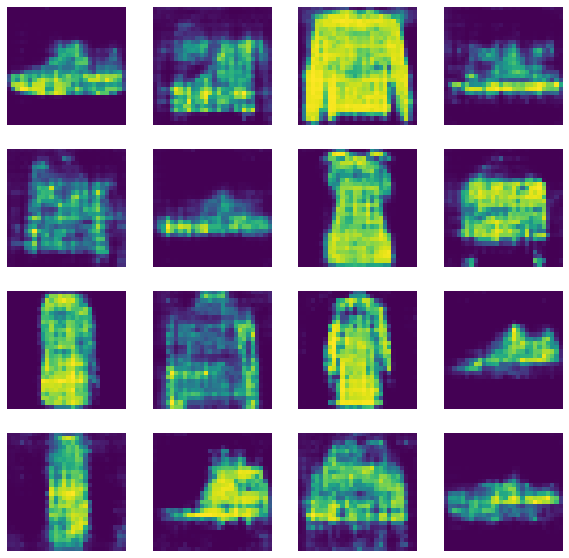

In [91]:
gen = generator()
disc = discriminator()

def train_step(input_image, labels):
    noise = tf.random.normal([batch_size, random_noise])
    noise = tf.concat(axis=1, values=[noise, np.stack(labels)])
    
    input_image = tf.concat(axis=1, values = [tf.cast(input_image, tf.float32), labels])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(noise)
        generated_images = tf.concat(axis=1, values=[generated_images, labels])
        real_output = disc(input_image)
        fake_output = disc(generated_images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    g_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
    g_disc = disc_tape.gradient(disc_loss, disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(g_gen, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(g_disc, disc.trainable_variables))
    return gen_loss,disc_loss
    
noise = tf.random.normal([batch_size, random_noise])
Y_label = np.zeros(shape = [batch_size, 10])
Y_label[:, 4] = 1    # For Coat
noise_gan = tf.concat(axis=1, values=[noise, Y_label])

def save_output(model, epoch):
    
    prediction = model(noise_gan)
    prediction = prediction.numpy().reshape(prediction.shape[0],28, 28, 1)
    
    fig = plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')
    plt.savefig('conditional_image_at_epoch_{:04d}.png'.format(epoch))
    
train_labels = tf.data.Dataset.from_tensor_slices(train_labels[:59968]).shuffle(128).batch(batch_size)
train_images = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0], 784)[:59968]).shuffle(128).batch(batch_size)

for epoch in range(epochs):
    start = time.time()

    for x_batch, labels in zip(train_images, train_labels):
        loss = train_step(x_batch, labels)
        
    if (epoch + 1) % break_num == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    if epoch %break_num ==0 or epoch==epochs-1 and epoch!=0:
        print ('Time for epoch {} is {} sec and Generator Loss :{} and Discriminator loss :{}'.format(epoch + 1, time.time()-start, loss[0], loss[1]))
        save_output(gen, epoch+1)

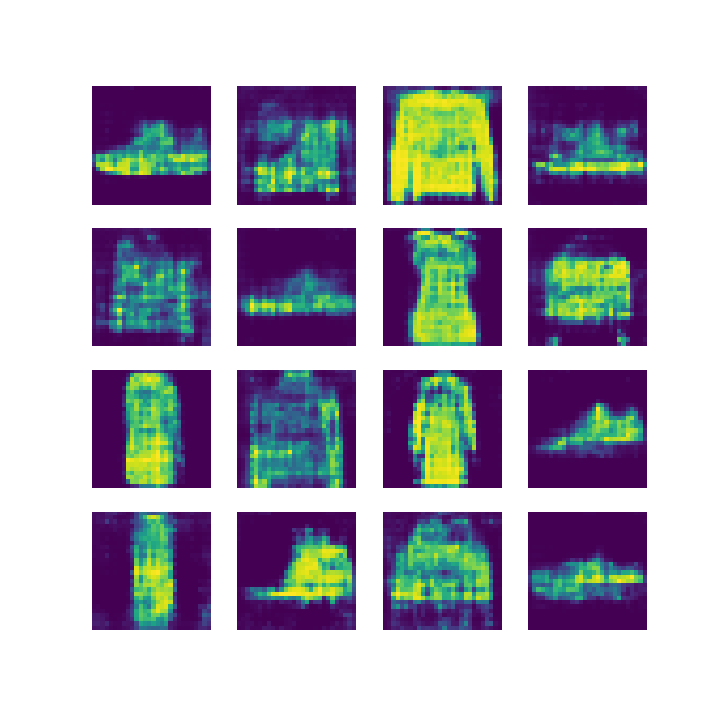

In [97]:
display_image(epoch+1, 'conditional_image_at_epoch_{:04d}.png')

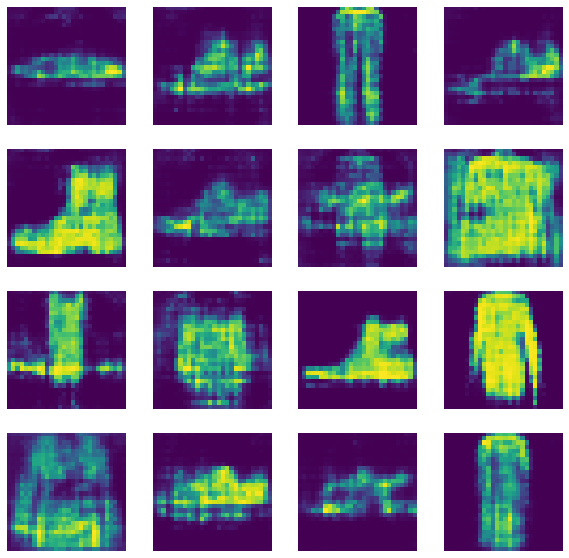

In [98]:
display.clear_output(wait=True)

noise = tf.random.normal([batch_size, random_noise])
feature_map = { "t-shirt":0,
                 "trouser":1,
                 "pullover":2,
                 "dress":3,
                 "coat":4,
                 "sandal":5,
                 "sirt":6,
                 "sneaker":7,
                 "bag":8,
                 "ankle boot": 9
                }
inp = "coat"

Y_label = np.zeros(shape = [batch_size, 10])
Y_label[:, feature_map[inp]] = 1
noise = tf.concat(axis=1, values=[noise, Y_label])

prediction = gen(noise)
prediction = prediction.numpy().reshape(prediction.shape[0],28, 28, 1)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5)
    plt.axis('off')
plt.show()


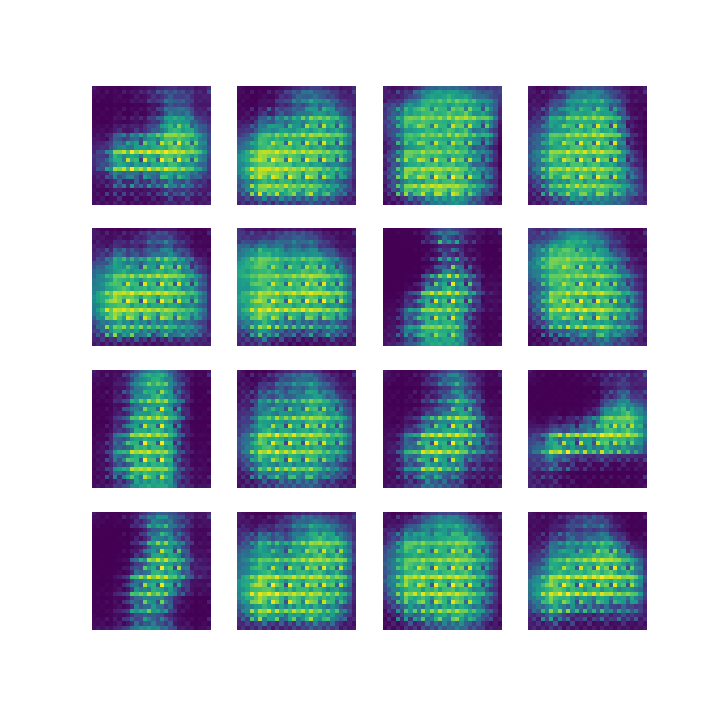

In [99]:
file = create_gif("result.gif", "conditional_image")
embed.embed_file(file)